In [1]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import time

import codecs
# Any results you write to the current directory are saved as output.

import os
import time
import re
import pickle
from datetime import datetime
import pytz
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Conv1D, MaxPool1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.layers import Dot, Lambda
from keras.layers import MaxPool1D, AveragePooling1D
from keras.layers import Add


from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

['train.csv', 'embeddings', 'test.csv']


Using TensorFlow backend.


CPU times: user 903 ms, sys: 1.29 s, total: 2.19 s
Wall time: 844 ms


In [2]:
from sklearn.metrics import roc_curve, precision_recall_curve
def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result 

In [3]:
model_epoch_dict = {'original-cnn1d':2, 'gru_atten_3':3, 'gru_srk_atten':2, 'lstm_du':2,
                   'my_lstm_atten':5, 'lstm_atten':3}
model_dict = {}
for model in model_epoch_dict:
    for emb in ['glove', 'para', 'mix']:
        model_dict['{}-{}'.format(model, emb)] = model_epoch_dict[model]

In [4]:
train_df = pd.read_csv("../input/train.csv")
train_y = train_df['target'].values


np.random.seed(2018)
trn_idx = np.random.permutation(train_y.shape[0])
train_y = train_y[trn_idx]


del train_df, trn_idx

In [5]:
from collections import OrderedDict

global_model_pred_dict_dict = {}

def load_pred(EXP_NAME):
    model_pred_dict = OrderedDict()
    for model_name in model_dict:
        for i_epoch in range(model_dict[model_name]):
            model_pred_dict[model_name + '-e' + str(i_epoch)] = np.load('../mydata/{}-e{}-{}.npy'.format(model_name, i_epoch, EXP_NAME))
    global_model_pred_dict_dict[EXP_NAME] = model_pred_dict

In [6]:
load_pred('mydrop0.2-maxf120-cleannum')

In [13]:
f1_list = []

In [14]:
# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix',
                   'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
epoch_list = [2, 2, 3, 3, 3, 5]
emb_list = ['glove', 'para', 'mix']

model_name_list_list = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            model_name_list_list.append(['original-cnn1d-{}'.format(emb_list[i]), 'lstm_du-{}'.format(emb_list[j]),
                   'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-{}'.format(emb_list[k])])

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for a_model_name_list in model_name_list_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])
    
    print(a_model_name_list)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    f1_list.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_list = a_model_name_list

print('best_model', best_f1, best_model_list)



['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3324801176786423, 'f1': 0.6969075500147315}
['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-para']
{'threshold': 0.33401408046483994, 'f1': 0.6968500077841653}
['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
{'threshold': 0.3395438964168231, 'f1': 0.6967118504469076}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
{'threshold': 0.3431851640343666, 'f1': 0.6970229317101545}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-para']
{'threshold': 0.33699651310841244, 'f1': 0.6962923303439968}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
{'threshold': 0.3282218451301257, 'f1': 0.6965426867636109}
['original-cnn1d-glove', 'lstm_du-mix

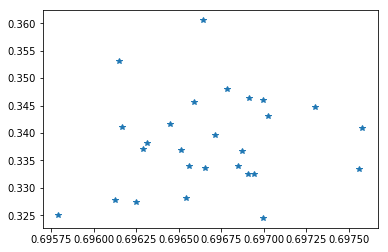

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
thresh_list = [d['threshold'] for d in f1_list]
f1_score_list = [d['f1'] for d in f1_list]

plt.plot(f1_score_list, thresh_list, '*')

In [16]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# 結果： 4epochも加えると良かった。
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0
for start_epoch in range(5):
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(start_epoch, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])
    
    print(start_epoch)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    f1_list.append(f1)
    
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_list = start_epoch

print('best_model', best_f1, best_model_list)



0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.33066843152046205, 'f1': 0.6951511185494472}
1
{'threshold': 0.3303184443049961, 'f1': 0.6961799357372367}
2
{'threshold': 0.3303372487425804, 'f1': 0.6972602422473887}
3
{'threshold': 0.3376061277730124, 'f1': 0.6976270318103487}
4
{'threshold': 0.34088894228140515, 'f1': 0.6975797463602341}
('best_model', {'threshold': 0.3376061277730124, 'f1': 0.6976270318103487}, 3)


In [17]:

load_pred('dropemb0.1-maxf120-cleannum')

In [20]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# 結果: 良くなった！　0.6978 lstm_atten-glove
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for changed_model in a_model_name_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == changed_model:
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
        
        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(3, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(changed_model)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    f1_list.append(f1)
    

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = changed_model

print('best_model', best_f1, best_model_list)



original-cnn1d-glove


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3364272138902119, 'f1': 0.6974779733776462}
lstm_du-mix
{'threshold': 0.3372009439127786, 'f1': 0.6971218303278642}
lstm_atten-mix
{'threshold': 0.3345537930727005, 'f1': 0.6970015750594281}
lstm_atten-glove
{'threshold': 0.32281708983438356, 'f1': 0.6977700639824951}
lstm_atten-para
{'threshold': 0.3381605680499758, 'f1': 0.6971986095288172}
my_lstm_atten-glove
{'threshold': 0.3364067854625838, 'f1': 0.6970120078190449}
('best_model', {'threshold': 0.32281708983438356, 'f1': 0.6977700639824951}, 'lstm_atten-glove')


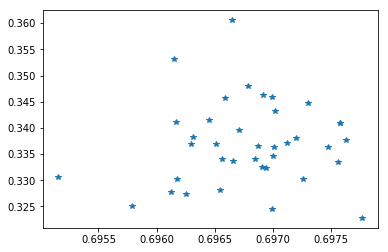

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
thresh_list = [d['threshold'] for d in f1_list]
f1_score_list = [d['f1'] for d in f1_list]

plt.plot(f1_score_list, thresh_list, '*')

In [15]:
# 'facal0.1-drop0.15-maxf120-cleannum'は'my_lstm_atten'しかないのでわちゃっとロード
from collections import OrderedDict
model_pred_dict = OrderedDict()
EXP_NAME = 'facal0.1-drop0.15-maxf120-cleannum'
for model_name in model_dict:
    if 'my_lstm_atten' in model_name:
        for i_epoch in range(model_dict[model_name]):
            model_pred_dict[model_name + '-e' + str(i_epoch)] = np.load('../mydata/{}-e{}-{}.npy'.format(model_name, i_epoch, EXP_NAME))
global_model_pred_dict_dict[EXP_NAME] = model_pred_dict

global_model_pred_dict_dict[EXP_NAME]

OrderedDict([('my_lstm_atten-glove-e0',
              array([0.00403349, 0.00746633, 0.00980563, ..., 0.02738783, 0.00148   ,
                     0.00368944])),
             ('my_lstm_atten-glove-e1',
              array([0.00185061, 0.010578  , 0.00664008, ..., 0.01901878, 0.00123746,
                     0.00260637])),
             ('my_lstm_atten-glove-e2',
              array([0.00099742, 0.00444742, 0.00376015, ..., 0.01815975, 0.0027316 ,
                     0.00196075])),
             ('my_lstm_atten-glove-e3',
              array([0.00053837, 0.0010374 , 0.00134775, ..., 0.01792705, 0.00368271,
                     0.00084124])),
             ('my_lstm_atten-glove-e4',
              array([0.00069597, 0.00240137, 0.00114471, ..., 0.00673308, 0.00443485,
                     0.00068397])),
             ('my_lstm_atten-para-e0',
              array([0.00185161, 0.00455027, 0.00288594, ..., 0.00494812, 0.00104161,
                     0.00290638])),
             ('my_lstm_atten-

In [19]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# 結果:　良かったね！
# 注： dropemb0.1に変わって無かった
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

changed_model = 'lstm_atten-glove'
pred_list = []
for model_name, epoch in zip(a_model_name_list, epoch_list):
    if model_name == changed_model:
        model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
    else:
        model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
        
    if model_name == 'my_lstm_atten-glove':
        model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
    else:
        model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
        
        
    if model_name == 'my_lstm_atten-glove':
        for i_epoch in range(3, 5):
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
    else:
        pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

print(changed_model)
f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
print(f1)

if f1 > best_f1:
    best_f1 = f1
    best_model_list = changed_model

print('best_model', best_f1, best_model_list)



lstm_atten-glove
{'threshold': 0.33181582178388325, 'f1': 0.6978865393163726}
('best_model', {'threshold': 0.33181582178388325, 'f1': 0.6978865393163726}, 'lstm_atten-glove')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


In [26]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# 結果:　良かったね！ 0.69819!

a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

changed_model = 'lstm_atten-glove'
pred_list = []
for model_name, epoch in zip(a_model_name_list, epoch_list):        
    if model_name == 'my_lstm_atten-glove':
        model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
    elif model_name == changed_model:
        model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
    else:
        model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
        
        
    if model_name == 'my_lstm_atten-glove':
        for i_epoch in range(3, 5):
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
    else:
        pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

print(changed_model)
f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
print(f1)

if f1 > best_f1:
    best_f1 = f1
    best_model_list = changed_model

print('best_model', best_f1, best_model_list)



lstm_atten-glove
{'threshold': 0.32937880020056454, 'f1': 0.6981926532678349}
('best_model', {'threshold': 0.32937880020056454, 'f1': 0.6981926532678349}, 'lstm_atten-glove')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


In [12]:
load_pred('facal0.1-drop0.2-maxf120-cleannum')

In [28]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# それぞれのモデルを'facal0.1-drop0.2-maxf120-cleannum'に変える
# 結果: 改善！ 0.6983
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for changed_model in a_model_name_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == changed_model:
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
        elif model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
        elif model_name == 'lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(3, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(changed_model)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = changed_model

print('best_model', best_f1, best_model_list)



original-cnn1d-glove


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.33618713915348053, 'f1': 0.6983268313827481}
lstm_du-mix
{'threshold': 0.33542426569121225, 'f1': 0.6977287175634281}
lstm_atten-mix
{'threshold': 0.33332130312919617, 'f1': 0.697893326557483}
lstm_atten-glove
{'threshold': 0.3294050821236202, 'f1': 0.697497398513272}
lstm_atten-para
{'threshold': 0.32819821153368267, 'f1': 0.6981747216163472}
my_lstm_atten-glove
{'threshold': 0.3403694470013891, 'f1': 0.6977613461034613}
('best_model', {'threshold': 0.33618713915348053, 'f1': 0.6983268313827481}, 'original-cnn1d-glove')


In [29]:
load_pred('facal-0.5-maxf120-cleannum')

In [30]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# それぞれのモデルを'facal0.1-drop0.2-maxf120-cleannum'に変える
# それぞれのモデルを'facal0.5-drop0.2-maxf120-cleannum'に変える
# 結果: 改善ならず、、、
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for changed_model in a_model_name_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == changed_model:
            model_pred_dict = global_model_pred_dict_dict['facal-0.5-maxf120-cleannum']
        elif model_name == 'original-cnn1d-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
        elif model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
        elif model_name == 'lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(3, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(changed_model)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = changed_model

print('best_model', best_f1, best_model_list)



original-cnn1d-glove


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3393978018845831, 'f1': 0.6978333256254914}
lstm_du-mix
{'threshold': 0.35554977506399155, 'f1': 0.6975643473880291}
lstm_atten-mix
{'threshold': 0.33656429180077146, 'f1': 0.6974416209779025}
lstm_atten-glove
{'threshold': 0.32670884153672625, 'f1': 0.697577902144274}
lstm_atten-para
{'threshold': 0.3447340040334633, 'f1': 0.6981513307631566}
my_lstm_atten-glove
{'threshold': 0.34540306457451414, 'f1': 0.6972778941070895}
('best_model', {'threshold': 0.3447340040334633, 'f1': 0.6981513307631566}, 'lstm_atten-para')


In [31]:
# 'decentattention-mydrop0.2-maxf120-cleannum'は'my_lstm_atten'しかないのでわちゃっとロード
from collections import OrderedDict
model_pred_dict = OrderedDict()
EXP_NAME = 'decentattention-mydrop0.2-maxf120-cleannum'
for model_name in model_dict:
    if 'my_lstm_atten' in model_name:
        for i_epoch in range(model_dict[model_name]):
            model_pred_dict[model_name + '-e' + str(i_epoch)] = np.load('../mydata/{}-e{}-{}.npy'.format(model_name, i_epoch, EXP_NAME))
global_model_pred_dict_dict[EXP_NAME] = model_pred_dict

global_model_pred_dict_dict[EXP_NAME]

OrderedDict([('my_lstm_atten-glove-e0',
              array([0.00166314, 0.00360725, 0.00629975, ..., 0.02006519, 0.00073392,
                     0.00136889])),
             ('my_lstm_atten-glove-e1',
              array([0.00158129, 0.00329392, 0.0054731 , ..., 0.01225291, 0.00055563,
                     0.0007273 ])),
             ('my_lstm_atten-glove-e2',
              array([0.00044721, 0.00220054, 0.0024593 , ..., 0.01120854, 0.000483  ,
                     0.00076872])),
             ('my_lstm_atten-glove-e3',
              array([0.00081329, 0.00128373, 0.00033246, ..., 0.00320884, 0.00050315,
                     0.00043774])),
             ('my_lstm_atten-glove-e4',
              array([0.00034584, 0.00081999, 0.00228238, ..., 0.0028434 , 0.00042105,
                     0.00026407])),
             ('my_lstm_atten-para-e0',
              array([0.00117236, 0.00350825, 0.00621313, ..., 0.00603794, 0.00148959,
                     0.00443065])),
             ('my_lstm_atten-

In [33]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# それぞれのモデルを'facal0.1-drop0.2-maxf120-cleannum'に変える
# そっからmy_lism だけdecentattention-mydrop0.2-maxf120-cleannumに変える
# 結果: 改善ならず、、、
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

pred_list = []
for model_name, epoch in zip(a_model_name_list, epoch_list):
    if model_name == 'original-cnn1d-glove':
        model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
    elif model_name == 'my_lstm_atten-glove':
        model_pred_dict = global_model_pred_dict_dict['decentattention-mydrop0.2-maxf120-cleannum']
    elif model_name == 'lstm_atten-glove':
        model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
    else:
        model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


    if model_name == 'my_lstm_atten-glove':
        for i_epoch in range(3, 5):
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
    else:
        pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

print(changed_model)
f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
print(f1)

if f1 > best_f1:
    best_f1 = f1
    best_model_list = changed_model

print('best_model', best_f1, best_model_list)



my_lstm_atten-glove
{'threshold': 0.34067204168864657, 'f1': 0.6973100694889016}
('best_model', {'threshold': 0.34067204168864657, 'f1': 0.6973100694889016}, 'my_lstm_atten-glove')


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える

結局良くなかった

In [21]:
# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える

a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix',
                   'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
epoch_list = [2, 2, 3, 3, 3, 5]
emb_list = ['glove', 'para', 'mix']

model_name_list_list = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            model_name_list_list.append(['original-cnn1d-{}'.format(emb_list[i]), 'lstm_du-{}'.format(emb_list[j]),
                   'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-{}'.format(emb_list[k])])

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0
for a_model_name_list in model_name_list_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
        pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])
    
    print(a_model_name_list)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_list = a_model_name_list

print('best_model', best_f1, best_model_list)



['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.33463436861832935, 'f1': 0.6972473887702696}
['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-para']
{'threshold': 0.33401408046483994, 'f1': 0.6968500077841653}
['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
{'threshold': 0.3395438964168231, 'f1': 0.6967118504469076}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
{'threshold': 0.32308853417634964, 'f1': 0.6969074059187634}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-para']
{'threshold': 0.33699651310841244, 'f1': 0.6962923303439968}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
{'threshold': 0.3282218451301257, 'f1': 0.6965426867636109}
['original-cnn1d-glove', 'lstm_du-m

In [22]:
# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# my_lstmのsnapshot ensemble
# 0.6977
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0
for start_epoch in range(5):
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
            
        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(start_epoch, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])
    
    print(start_epoch)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_list = start_epoch

print('best_model', best_f1, best_model_list)



0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.33685894012451173, 'f1': 0.6943405306003197}
1
{'threshold': 0.34095638659265304, 'f1': 0.6961500834436324}
2
{'threshold': 0.3433657083660364, 'f1': 0.6970995748827012}
3
{'threshold': 0.3349489058767046, 'f1': 0.6977255335186049}
4
{'threshold': 0.33463436861832935, 'f1': 0.6972473887702696}
('best_model', {'threshold': 0.3349489058767046, 'f1': 0.6977255335186049}, 3)


In [25]:
# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える

a_model_name_list = ['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for changed_model in a_model_name_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):     
        if model_name == 'my_lstm_atten-glove':
            EXP_NAME = 'facal0.1-drop0.15-maxf120-cleannum'
        elif model_name == changed_model:
            EXP_NAME = 'dropemb0.1-maxf120-cleannum'
        else:
            EXP_NAME = 'mydrop0.2-maxf120-cleannum'
        
        print(changed_model, model_name, EXP_NAME)
        model_pred_dict = global_model_pred_dict_dict[EXP_NAME]
        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(3, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(changed_model)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = changed_model

print('best_model', best_f1, best_model_list)



('original-cnn1d-glove', 'original-cnn1d-glove', 'dropemb0.1-maxf120-cleannum')
('original-cnn1d-glove', 'lstm_du-glove', 'mydrop0.2-maxf120-cleannum')
('original-cnn1d-glove', 'lstm_atten-mix', 'mydrop0.2-maxf120-cleannum')
('original-cnn1d-glove', 'lstm_atten-glove', 'mydrop0.2-maxf120-cleannum')
('original-cnn1d-glove', 'lstm_atten-para', 'mydrop0.2-maxf120-cleannum')
('original-cnn1d-glove', 'my_lstm_atten-glove', 'facal0.1-drop0.15-maxf120-cleannum')
original-cnn1d-glove


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3389299511909485, 'f1': 0.6973582396671003}
('lstm_du-glove', 'original-cnn1d-glove', 'mydrop0.2-maxf120-cleannum')
('lstm_du-glove', 'lstm_du-glove', 'dropemb0.1-maxf120-cleannum')
('lstm_du-glove', 'lstm_atten-mix', 'mydrop0.2-maxf120-cleannum')
('lstm_du-glove', 'lstm_atten-glove', 'mydrop0.2-maxf120-cleannum')
('lstm_du-glove', 'lstm_atten-para', 'mydrop0.2-maxf120-cleannum')
('lstm_du-glove', 'my_lstm_atten-glove', 'facal0.1-drop0.15-maxf120-cleannum')
lstm_du-glove
{'threshold': 0.3176954984664917, 'f1': 0.6975645385861998}
('lstm_atten-mix', 'original-cnn1d-glove', 'mydrop0.2-maxf120-cleannum')
('lstm_atten-mix', 'lstm_du-glove', 'mydrop0.2-maxf120-cleannum')
('lstm_atten-mix', 'lstm_atten-mix', 'dropemb0.1-maxf120-cleannum')
('lstm_atten-mix', 'lstm_atten-glove', 'mydrop0.2-maxf120-cleannum')
('lstm_atten-mix', 'lstm_atten-para', 'mydrop0.2-maxf120-cleannum')
('lstm_atten-mix', 'my_lstm_atten-glove', 'facal0.1-drop0.15-maxf120-cleannum')
lstm_atten-mix
{'thresho

In [34]:
# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
# my_lstm_attenをdecentattention-mydrop0.2-maxf120-cleannumに変える
# よくない、、、なんでやろうねlocal 回す
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix',
                   'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
epoch_list = [2, 2, 3, 3, 3, 5]
emb_list = ['glove', 'para', 'mix']

model_name_list_list = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            model_name_list_list.append(['original-cnn1d-{}'.format(emb_list[i]), 'lstm_du-{}'.format(emb_list[j]),
                   'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-{}'.format(emb_list[k])])

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0
for a_model_name_list in model_name_list_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['decentattention-mydrop0.2-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
        pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])
    
    print(a_model_name_list)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_list = a_model_name_list

print('best_model', best_f1, best_model_list)



['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3360569402575493, 'f1': 0.6966168780515991}
['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-para']
{'threshold': 0.33401408046483994, 'f1': 0.6968500077841653}
['original-cnn1d-glove', 'lstm_du-glove', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
{'threshold': 0.3395438964168231, 'f1': 0.6967118504469076}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
{'threshold': 0.3391367221872012, 'f1': 0.6969877130400317}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-para']
{'threshold': 0.33699651310841244, 'f1': 0.6962923303439968}
['original-cnn1d-glove', 'lstm_du-para', 'lstm_atten-mix', 'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-mix']
{'threshold': 0.3282218451301257, 'f1': 0.6965426867636109}
['original-cnn1d-glove', 'lstm_du-mix

In [35]:
# 'mydrop0.2-maxf120-cleannum' の アンサンブル探し
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# my_lstmのsnapshot ensemble
# 全然良くない
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0
for start_epoch in range(5):
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['decentattention-mydrop0.2-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
            
        if model_name == 'my_lstm_atten-glove':
            for i_epoch in range(start_epoch, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])
    
    print(start_epoch)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_list = start_epoch

print('best_model', best_f1, best_model_list)



0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3505921483039856, 'f1': 0.6933463210829907}
1
{'threshold': 0.35545142988363904, 'f1': 0.6950798013518455}
2
{'threshold': 0.34371230006217957, 'f1': 0.6960704291044776}
3
{'threshold': 0.33666571761880604, 'f1': 0.6965643087937887}
4
{'threshold': 0.3387486934661865, 'f1': 0.6970736488378606}
('best_model', {'threshold': 0.3387486934661865, 'f1': 0.6970736488378606}, 4)


In [10]:
def load_concat():
    EXP_NAME = 'concat-focal0.1-drop0.1-maxf120-cleannum'
    model_epoch_dict = {'original-cnn1d':2, 'gru_atten_3':3, 'gru_srk_atten':2, 'lstm_du':2,
                       'my_lstm_atten':5, 'lstm_atten':3}
    model_dict = {}
    for model in model_epoch_dict:
        for emb in ['concat']:
            model_dict['{}-{}'.format(model, emb)] = model_epoch_dict[model]

    model_pred_dict = OrderedDict()
    for model_name in model_dict:
        for i_epoch in range(model_dict[model_name]):
            model_pred_dict[model_name + '-e' + str(i_epoch)] = np.load('../mydata/{}-e{}-{}.npy'.format(model_name, i_epoch, EXP_NAME))

    global_model_pred_dict_dict[EXP_NAME] = model_pred_dict  

## concat を混ぜてみる

In [11]:
load_concat()

In [18]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# 'original-cnn1d-glove' を 'facal0.1-drop0.2-maxf120-cleannum'に変える
# concatをそれぞれのモデルに変えてみる
# 改善、 0.69899、　でもモデル減らさないとアカンで、
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for changed_model in a_model_name_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == changed_model:
            model_pred_dict = global_model_pred_dict_dict['concat-focal0.1-drop0.1-maxf120-cleannum']
            model_name = '-'.join(model_name.split('-')[:-1]+['concat'])
        elif model_name == 'original-cnn1d-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
        elif model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.15-maxf120-cleannum']
        elif model_name == 'lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


        if model_name == 'my_lstm_atten-glove' or model_name == 'my_lstm_atten-concat': 
            for i_epoch in range(3, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(changed_model)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = changed_model

print('best_model', best_f1, best_model_list)



original-cnn1d-glove


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.339840971997806, 'f1': 0.6981766725433795}
lstm_du-mix
{'threshold': 0.3414138677929129, 'f1': 0.6976142486702511}
lstm_atten-mix
{'threshold': 0.338747107556888, 'f1': 0.6979016692975305}
lstm_atten-glove
{'threshold': 0.34474117841039387, 'f1': 0.6983900526596608}
lstm_atten-para
{'threshold': 0.3413385642426355, 'f1': 0.6980432960490188}
my_lstm_atten-glove
{'threshold': 0.34081699699163437, 'f1': 0.6989966749261578}
('best_model', {'threshold': 0.34081699699163437, 'f1': 0.6989966749261578}, 'my_lstm_atten-glove')


In [20]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# 'original-cnn1d-glove' を 'facal0.1-drop0.2-maxf120-cleannum'に変える
# concatで'my_lstm_atten-glove'モデルを変える

a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for start_epoch in range(5):
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['concat-focal0.1-drop0.1-maxf120-cleannum']
            model_name = 'my_lstm_atten-concat'
        elif model_name == 'original-cnn1d-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
        elif model_name == 'lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


        if model_name == 'my_lstm_atten-concat': 
            for i_epoch in range(start_epoch, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(start_epoch)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = start_epoch

print('best_model', best_f1, best_model_list)



0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.34440215975046157, 'f1': 0.6970341431840773}
1
{'threshold': 0.34614824917581344, 'f1': 0.6978694245878506}
2
{'threshold': 0.32706788275390863, 'f1': 0.6985140793976337}
3
{'threshold': 0.34081699699163437, 'f1': 0.6989966749261578}
4
{'threshold': 0.347367783387502, 'f1': 0.6983343398040607}
('best_model', {'threshold': 0.34081699699163437, 'f1': 0.6989966749261578}, 3)


In [21]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# 'original-cnn1d-glove' を 'facal0.1-drop0.2-maxf120-cleannum'に変える
# concatで'my_lstm_atten-glove'モデルを変える
# concat で 4epochまで、良くない、、、
a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for start_epoch in range(4):
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['concat-focal0.1-drop0.1-maxf120-cleannum']
            model_name = 'my_lstm_atten-concat'
        elif model_name == 'original-cnn1d-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
        elif model_name == 'lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


        if model_name == 'my_lstm_atten-concat': 
            for i_epoch in range(start_epoch, 4):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(start_epoch)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = start_epoch

print('best_model', best_f1, best_model_list)



0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.353082032667266, 'f1': 0.6960283588703094}
1
{'threshold': 0.3451586402952671, 'f1': 0.6972660333093308}
2
{'threshold': 0.3357772486550467, 'f1': 0.6978770047305872}
3
{'threshold': 0.34069904685020447, 'f1': 0.6979110935355557}
('best_model', {'threshold': 0.34069904685020447, 'f1': 0.6979110935355557}, 3)


In [22]:
# 'mydrop0.2-maxf120-cleannum' の 一番いいアンサンブル で、 my_lstmのsnapshot ensemble
# dropemb0.1のモデルをそれぞれ入れ替える
# my_lstm_attenを'facal0.1-drop0.15-maxf120-cleannum'に変える
# 'original-cnn1d-glove' を 'facal0.1-drop0.2-maxf120-cleannum'に変える
# concatで'my_lstm_atten-glove'モデルを変える
# concat で 4epochまで、良くない、、、
# よかった！ lstm-atten-para抜いても, 0.6987

a_model_name_list = ['original-cnn1d-glove', 'lstm_du-mix', 'lstm_atten-mix',
                     'lstm_atten-glove', 'lstm_atten-para', 'my_lstm_atten-glove']
epoch_list = [2, 2, 3, 3, 3, 5]

model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']
best_f1 = 0

for changed_model in a_model_name_list:
    pred_list = []
    for model_name, epoch in zip(a_model_name_list, epoch_list):
        if model_name == changed_model:
            continue
            
        if model_name == 'my_lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['concat-focal0.1-drop0.1-maxf120-cleannum']
            model_name = 'my_lstm_atten-concat'
        elif model_name == 'original-cnn1d-glove':
            model_pred_dict = global_model_pred_dict_dict['facal0.1-drop0.2-maxf120-cleannum']
        elif model_name == 'lstm_atten-glove':
            model_pred_dict = global_model_pred_dict_dict['dropemb0.1-maxf120-cleannum']
        else:
            model_pred_dict = global_model_pred_dict_dict['mydrop0.2-maxf120-cleannum']


        if model_name == 'my_lstm_atten-concat': 
            for i_epoch in range(3, 5):
                pred_list.append(model_pred_dict['{}-e{}'.format(model_name, i_epoch)])
        else:
            pred_list.append(model_pred_dict['{}-e{}'.format(model_name, epoch-1)])

    print(changed_model)
    f1 = threshold_search(train_y, np.mean(pred_list, axis=0))
    print(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model_list = changed_model

print('best_model', best_f1, best_model_list)



original-cnn1d-glove


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """


{'threshold': 0.3520306771000226, 'f1': 0.6985904682157561}
lstm_du-mix
{'threshold': 0.3423985888560613, 'f1': 0.6984084696288746}
lstm_atten-mix
{'threshold': 0.3346717208623886, 'f1': 0.6983024155260659}
lstm_atten-glove
{'threshold': 0.33786434680223465, 'f1': 0.6983154848046311}
lstm_atten-para
{'threshold': 0.3266719902555148, 'f1': 0.6987014177812927}
my_lstm_atten-glove
{'threshold': 0.3321556106209755, 'f1': 0.6958964408792099}
('best_model', {'threshold': 0.3266719902555148, 'f1': 0.6987014177812927}, 'lstm_atten-para')
